## Libraries

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import product

import json

from typing import Tuple, List, Dict, Set, Optional

import random
from tqdm import tqdm

import pickle
import matplotlib.pyplot as plt

import ast

## Data Preparation

In [5]:
# 변환 용 dict
id2ent = pd.read_pickle("data/FB15k-237-betae/id2ent.pkl")
id2rel = pd.read_pickle("data/FB15k-237-betae/id2rel.pkl")
ent2id = {v:k for k, v in id2ent.items()}
rel2id = {v:k for k, v in id2rel.items()}

# Q2T Graph 데이터 셋
with open("data/FB15k-237-betae/train.txt") as f_train:
    train = f_train.read()
train = train.split('\n')
print(len(train))
print(len(train)/2)
stat = list(map(lambda x: (int(x.split('\t')[0]), int(x.split('\t')[1]), int(x.split('\t')[2])), train)) # 통계확인 시 사용하는 데이터셋
predicate1 = set(list(map(lambda x: (id2ent[int(x.split('\t')[0])], id2rel[int(x.split('\t')[1])]), train)))
entity = set(list(map(lambda x: id2ent[int(x.split('\t')[0])], train)))
print("Entities: ", len(entity))
print(len(predicate1))
train = list(map(lambda x: (id2ent[int(x.split('\t')[0])], id2rel[int(x.split('\t')[1])], id2ent[int(x.split('\t')[2])]), train))

with open("data/ent2txt.json", 'r') as f:
    ent2txt = json.loads(f.read())

544230
272115.0
Entities:  14505
149689


## 데이터 통계

In [6]:
stat = pd.DataFrame(stat)

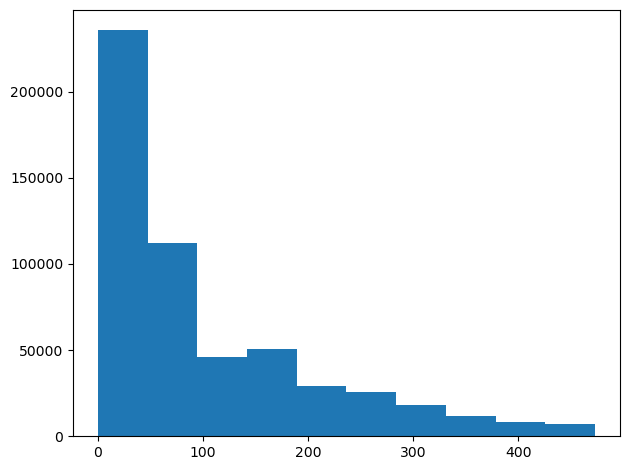

In [8]:
import matplotlib.pyplot as plt

# plt.subplot(131)
# plt.hist(stat[0])
# plt.subplot(132)
plt.hist(stat[1])
# plt.subplot(133)
# plt.hist(stat[2])

plt.tight_layout()

In [70]:
# len(stat[1])

In [71]:
# len(stat[1][stat[1] > 200])

## Graph Construction

In [72]:
def to_networkx(triples: List[Tuple[str, str, str]],
                entity_to_idx: Dict[str, int],
                predicate_to_idx: Dict[str, int],
                predicates: Optional[Set[str]] = None,
                is_multidigraph: bool = False) -> nx.DiGraph:
    _triples = triples if predicates is None else [(s, p, o) for s, p, o in triples if p in predicates]

    G = nx.MultiDiGraph() if is_multidigraph else nx.DiGraph()

    entities = sorted({s for (s, _, _) in triples} | {o for (_, _, o) in triples})
    G.add_nodes_from([entity_to_idx[e] for e in entities])

    if is_multidigraph:
        G.add_edges_from([(entity_to_idx[s], entity_to_idx[o], {'p': predicate_to_idx[p]}) for s, p, o in _triples])
    else:
        edge_lst = sorted({(entity_to_idx[s], entity_to_idx[o]) for s, p, o in _triples})
        G.add_edges_from(edge_lst)

    return G

In [73]:
# MultiDirectedGraph
mG = to_networkx(train, ent2id, rel2id, None, is_multidigraph=True)

## Random query 생성

In [74]:
org_train = pd.read_csv("data/FB15k-237-train.csv")
org_valid = pd.read_csv("data/FB15k-237-valid.csv")
org_test = pd.read_csv("data/FB15k-237-test.csv")

org_train = org_train.iloc[:, 20::2].reset_index()
org_valid = org_valid.iloc[:, 28::3].reset_index()
org_test = org_test.iloc[:, 28::3].reset_index()



/tmp/ipykernel_115581/4187586199.py:1: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,30,31,32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  org_train = pd.read_csv("data/FB15k-237-train.csv")
/tmp/ipykernel_115581/4187586199.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  org_valid = pd.read_csv("data/FB15k-237-valid.csv")
/tmp/ipykernel_115581/4187586199.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  org_test = pd.read_csv("data/FB15k-237-test.c

In [75]:
references = pd.concat([org_train, org_valid, org_test]).reset_index(drop=True)
references

,index,1p_origin,2p_origin,3p_origin,2i_origin,3i_origin,2in_origin,3in_origin,inp_origin,pin_origin,pni_origin,ip_origin,pi_origin,2u_origin,up_origin
0,0,"(3793, (107,))","(4582, (133, 17))","(4526, (95, 364, 39))","((5588, (135,)), (3239, (95,)))","((1730, (35,)), (2669, (7,)), (3587, (17,)))","((135, (13,)), (8594, (154, -2)))","((2263, (12,)), (1080, (57,)), (3352, (4, -2)))","(((1306, (298,)), (954, (49, -2))), (25,))","((2410, (4, 65)), (592, (167, -2)))","((4157, (348, 208, -2)), (389, (131,)))",NaN,NaN,NaN,NaN
1,1,"(6290, (3,))","(3154, (150, 456))","(11341, (12, 5, 225))","((5179, (41,)), (5027, (104,)))","((344, (161,)), (117, (11,)), (5147, (340,)))","((9891, (13,)), (7862, (155, -2)))","((1285, (21,)), (2192, (365,)), (8219, (21, -2)))","(((6805, (21,)), (1641, (15, -2))), (20,))","((32, (97, 80)), (13643, (80, -2)))","((62, (51, 121, -2)), (548, (17,)))",NaN,NaN,NaN,NaN
2,2,"(3725, (461,))","(7364, (61, 375))","(2273, (341, 34, 362))","((138, (84,)), (1415, (35,)))","((12649, (117,)), (10511, (116,)), (1046, (30,)))","((5983, (100,)), (871, (35, -2)))","((6607, (63,)), (32, (57,)), (1854, (211, -2)))","(((11855, (290,)), (11210, (4, -2))), (60,))","((1529, (320, 31)), (1124, (174, -2)))","((2864, (209, 161, -2)), (5445, (188,)))",NaN,NaN,NaN,NaN
3,3,"(8965, (41,))","(6187, (263, 176))","(13948, (240, 453, 143))","((141, (87,)), (491, (16,)))","((645, (169,)), (4161, (233,)), (367, (219,)))","((4215, (152,)), (1271, (269, -2)))","((32, (57,)), (6438, (169,)), (4130, (25, -2)))","(((1242, (2,)), (14132, (49, -2))), (48,))","((2477, (16, 6)), (1327, (79, -2)))","((159, (13, 90, -2)), (8556, (2,)))",NaN,NaN,NaN,NaN
4,4,"(2489, (34,))","(10789, (167, 286))","(372, (226, 88, 332))","((774, (237,)), (11041, (119,)))","((774, (237,)), (12645, (34,)), (8360, (92,)))","((4494, (1,)), (6473, (443, -2)))","((1974, (94,)), (1253, (142,)), (4626, (2, -2)))","(((26, (26,)), (190, (437, -2))), (125,))","((494, (183, 375)), (173, (13, -2)))","((774, (237, 97, -2)), (4448, (13,)))",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192582,22799,"(692, (96,))",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192583,22800,"(2845, (127,))",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192584,22801,"(1987, (184,))",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192585,22802,"(5959, (86,))",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
predicate =  references['1p_origin'].dropna().reset_index(drop=True).tolist()
entity = predicate
print(len(set(predicate)))

161882


In [77]:
# entity list
entity_list = list(id2ent.keys())

successors 수와 out-degree의 수치가 일치하지 않음 ==> 같은 노드 간에 여러 개의 edge가 있다는 의미 (e.g. (e1, r1, e2), (e1, r2, e2))

In [78]:
out_degree = dict(mG.out_degree)
in_degree = dict(mG.in_degree)

print(len(list(mG.successors(0))))
print(out_degree[0])

# multiEdge인 경우의 예시
print(id2rel[141])
print(id2rel[442])


successors = []
for i in entity_list:
    successors.append(len(list(mG.successors(i))))

print('\n')

print("평균 Successor 수: ", np.mean(successors))
print("평균 out-degree: ", np.mean(list(out_degree.values())))
print("평균 in-degree: ", np.mean(list(in_degree.values())))

print("median Successor 수: ", np.median(successors))
print("median out-degree: ", np.median(list(out_degree.values())))
print("median in-degree: ", np.median(list(in_degree.values())))

print("Max successors: ", max(successors))
print("Max out-degree: ", max(list(out_degree.values())))
print("Max in-degree: ", max(list(in_degree.values())))

print("가장 많은 successor를 가진 entity: ", ent2txt[id2ent[32]])
print("가장 많은 out-degree를 가진 entity: ", ent2txt[id2ent[10390]])



41
47
-/language/human_language/countries_spoken_in
+/location/country/official_language


평균 Successor 수:  29.166218545329198
평균 out-degree:  37.52016546018614
평균 in-degree:  37.52016546018614
median Successor 수:  18.0
median out-degree:  22.0
median in-degree:  22.0
Max successors:  5984
Max out-degree:  7614
Max in-degree:  7614
가장 많은 successor를 가진 entity:  United States of America
가장 많은 out-degree를 가진 entity:  1985 NCAA Men's Division I Basketball Tournament


In [79]:
# degree_wgh이 더 작을 수록 각 query별 answer의 다양성이 높아짐

degree_wgh_ctrl = 40
# wgh1= degree_wgh_ctrl
# wgh2 = degree_wgh_ctrl
wgh1 = 5000
# wgh1= degree_wgh_ctrl ** (1/3)
wgh2 = degree_wgh_ctrl ** (1/4)

In [80]:
def query_counter(q_type, query):
    print(f"The number of {q_type} queries: ", len(query.keys()))


In [81]:
def sample_candidate(successors_weight):
    number_of_samples = 1
    return random.choices(range(0, 14505) , weights = successors_weight, k = number_of_samples)

In [82]:
entity_dict_whole = {}
relation_dict_whole = {}

query_data = {} # 최종 query data
answer_data = {} # 최종 answer data

In [83]:
# degree_wgh이 더 작을 수록 각 query별 answer의 다양성이 높아짐
degree_wgh = 3560

In [90]:
# query_type = "1p.2p.3p.2i.3i.ip.pi.2in.3in.inp.pin.pni.2u.up"
query_type = "3p"
query_type_list = [q for q in query_type.split('.')]

successors_weight = list(map(lambda x: 1/x, successors))

# number_of_samples = 1036
# whole_candidates = random.choices(range(0, 14505) , weights = successors_weight, k = number_of_samples*14)

sort = False
suffle = True
diversity_rel = False
diversity_entity = False
limit = 3860

for num_q, q_type in enumerate(query_type_list):
    
    # queries = []
    # answer = []
    # bounded_entities = []
    query_to_answers = {}
    if q_type == "1p":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)
        print("1p query generating ...")

        for i in tqdm(entity_candidates):
            # 1p
            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)

            # print(edges1)

            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)
            # if suffle:
            #     edges1 = list(edges1)
            #     random.shuffle(edges1)
            #     print(edges1)


            for itr_count1, (start, end, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh1:
                        break
                rel1 = tuple(data1.values())

                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue

                query = (start, rel1)
                if str(query) in set(references['1p_origin'].dropna().reset_index(drop=True).tolist()):
                    continue


                if query not in query_to_answers:
                    query_to_answers[query] = {'answer': [], 'bounded': []}

                query_to_answers[query]['answer'].append(end)

                # Statistics calculation
                entity_dict[start] = entity_dict.get(start, 0) + 1
                relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                entity_dict_whole[start] = entity_dict_whole.get(start, 0) + 1
                relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                # print(f"출발 노드: {start}, 도착 노드: {end}, 데이터: {tuple(rel)}")

        print("1p query generating finished")
        existing_set = query_data.get(('e', ('r',)), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[('e', ('r',))] = new_set

        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[('e', ('r',))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "2p":
        entity_dict = {}
        relation_dict = {}
        
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)
        print("2p query generating ...")

        for i in tqdm(entity_candidates):
            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)

            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            for itr_count1, (start, bounded1, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh1:
                        break
                rel1 = tuple(data1.values())  # 첫 번째 edge

                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.out_edges(bounded1, keys=False, data=True)

                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)
                
                for itr_count2, (_, end, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh1:
                            break

                    rel2 = tuple(data2.values())

                    # loop query 방지
                    if end == start:
                        continue
                    if rel2 % 2 == 0 and rel1 == rel2+1:
                        continue
                    elif rel1 == rel2-1:
                        continue

                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
                    query = (start, rel1 + rel2)

                    if str(query) in set(references['2p_origin'].dropna().reset_index(drop=True).tolist()):
                        continue
                    if query not in query_to_answers:
                        query_to_answers[query] = {'answer': [], 'bounded': []}
                    query_to_answers[query]['answer'].append(end)
                    query_to_answers[query]['bounded'].append(bounded1)

                    # Statistics calculation
                    entity_dict[start] = entity_dict.get(start, 0) + 1
                    relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                    relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                    entity_dict_whole[start] = entity_dict_whole.get(start, 0) + 1
                    relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                    relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1
                    
        print("2p query generating finished")
        existing_set = query_data.get(('e', ('r', 'r')), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[('e', ('r', 'r'))] = new_set

        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[('e', ('r', 'r'))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "3p":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)
        print("3p query generating ...")

        for i in tqdm(entity_candidates):

            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)

            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            for itr_count1, (start, bounded1, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh2:
                        break
                rel1 = tuple(data1.values())  # 첫 번째 edge

                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.out_edges(bounded1, keys=False, data=True)

                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)
                for itr_count2, (_, bounded2, data2) in enumerate(tqdm(edges2)):
                    if diversity_entity:
                        if itr_count2 >= wgh2:
                            break

                    rel2 = tuple(data2.values())

                    # loop query 방지
                    if bounded2 == start:
                        continue
                    if rel2 % 2 == 0 and rel1 == rel2+1: # rel2가 짝수면 바로 다음 홀수랑 pair이므로 rel1이 rel2보다 바로 다음으로 더 큰 홀수인지 확인
                        continue
                    elif rel1 == rel2-1:
                        continue


                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue
                    # 세 번째 edge
                    edges3 = mG.out_edges(bounded2, keys=False, data=True)
                    for itr_count3, (_, end, data3) in enumerate(edges3):
                        if diversity_entity:
                            if itr_count3 >= wgh2:
                                break

                        rel3 = tuple(data3.values())
                        
                        # loop query 방지
                        if end == start or end == bounded1:
                            continue
                        if rel3 % 2 == 0 and rel2 == rel3+1:
                            continue
                        elif rel2 == rel3-1:
                            continue

                        if diversity_rel:
                            if relation_dict_whole.get(rel3[0], 0) >= limit:
                                continue
                            if relation_dict.get(rel3[0], 0) >= degree_wgh:
                                continue
                        # print(f"출발 노드: {start}, 중간 노드: {(bounded1, bounded2)}, 도착 노드: {end}, 데이터: {rel1 + rel2 + rel3}")

                        query = (start, rel1 + rel2 + rel3)

                        if str(query) in set(references['3p_origin'].dropna().reset_index(drop=True).tolist()):
                            continue

                        if query not in query_to_answers:
                            query_to_answers[query] = {'answer': [], 'bounded': []}
                        query_to_answers[query]['answer'].append(end)
                        query_to_answers[query]['bounded'].append((bounded1, bounded2))

                        # Statistics calculation
                        entity_dict[start] = entity_dict.get(start, 0) + 1
                        relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                        relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                        relation_dict[rel3[0]] = relation_dict.get(rel3[0], 0) + 1
                        entity_dict_whole[start] = entity_dict_whole.get(start, 0) + 1
                        relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                        relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1
                        relation_dict_whole[rel3[0]] = relation_dict_whole.get(rel3[0], 0) + 1
        print("3p query generating finished")
        existing_set = query_data.get(('e', ('r', 'r', 'r')), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[('e', ('r', 'r', 'r'))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[('e', ('r', 'r', 'r'))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "2i":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("2i query generating ...")
        for i in tqdm(entity_candidates):
            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)

            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            # 첫 번째 edge
            for itr_count1, (start1, end, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh1:
                        break
                rel1 = tuple(data1.values())
                
                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.in_edges(end, keys=False, data=True)
                for itr_count2, (start2, _, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh1:
                            break
                    
                    # loop query 방지
                    if start2 == start1:
                        continue

                    rel2 = tuple(data2.values())

                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    query = ((start1, rel1), (start2, rel2))

                    if str(query) in set(references['2i_origin'].dropna().reset_index(drop=True).tolist()):
                        continue
                    if query not in query_to_answers:
                        query_to_answers[query] = {'answer': [], 'bounded': []}
                    query_to_answers[query]['answer'].append(end)
                    
                    # 결과 출력 및 저장
                    # print(f"출발 노드1: {start1}, 출발 노드2: {start2}, 도착 노드: {end}, 데이터: {rel1 + rel2}")

                    # Statistics calculation
                    entity_dict[start1] = entity_dict.get(start1, 0) + 1
                    entity_dict[start2] = entity_dict.get(start2, 0) + 1
                    relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                    relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                    entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                    entity_dict_whole[start2] = entity_dict_whole.get(start2, 0) + 1
                    relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                    relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1

        print("2i query generating finished")
        # query_data[(('e', ('r',)), ('e', ('r',)))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})

        existing_set = query_data.get((('e', ('r',)), ('e', ('r',))), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[(('e', ('r',)), ('e', ('r',)))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        query_counter(q_type, query_to_answers)
    elif q_type == "3i":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("3i query generating ...")
        for i in tqdm(entity_candidates):
        
            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)
            
            # if sort:
            #     edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            # 첫 번째 edge
            for itr_count1, (start1, end, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh1:
                        break

                rel1 = tuple(data1.values())

                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                num_rel = 0
                
                # 두 번째 edge
                edges2 = mG.in_edges(end, keys=False, data=True)
                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)

                for itr_count2, (start2, _, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh1:
                            break

                    if start2 == start1:
                        continue

                    if num_rel == 0:
                        start2_1 = start2
                        rel2 = tuple(data2.values())

                        if diversity_rel:
                            if relation_dict_whole.get(rel2[0], 0) >= limit:
                                continue
                            if relation_dict.get(rel2[0], 0) >= degree_wgh:
                                continue
                    elif num_rel == 1:
                        start2_2 = start2
                        rel3 = tuple(data2.values())

                        if diversity_rel:
                            if relation_dict_whole.get(rel3[0], 0) >= limit:
                                continue
                            if relation_dict.get(rel3[0], 0) >= degree_wgh:
                                continue
                    num_rel += 1
                        
                    if num_rel == 2:
                        query = ((start1, rel1), (start2_1, rel2), (start2_2, rel3))

                        if str(query) in set(references['3i_origin'].dropna().reset_index(drop=True).tolist()):
                            continue

                        if query not in query_to_answers:
                            query_to_answers[query] = {'answer': [], 'bounded': []}
                        query_to_answers[query]['answer'].append(end)
                        num_rel = 0
                        
                        # 결과 출력 및 저장
                        # print(f"출발 노드1: {start1}, 출발 노드2: {start2_1}, 출발 노드3: {start2_2}, 도착 노드: {end}, 데이터: {rel1 + rel2 + rel3}")

                        # Statistics calculation
                        entity_dict[start1] = entity_dict.get(start1, 0) + 1
                        entity_dict[start2_1] = entity_dict.get(start2_1, 0) + 1
                        entity_dict[start2_2] = entity_dict.get(start2_2, 0) + 1
                        relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                        relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                        relation_dict[rel3[0]] = relation_dict.get(rel3[0], 0) + 1
                        entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                        entity_dict_whole[start2_1] = entity_dict_whole.get(start2_1, 0) + 1
                        entity_dict_whole[start2_2] = entity_dict_whole.get(start2_2, 0) + 1
                        relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                        relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1
                        relation_dict_whole[rel3[0]] = relation_dict_whole.get(rel3[0], 0) + 1

        print("3i query generating finished")
        existing_set = query_data.get((('e', ('r',)), ('e', ('r',)), ('e', ('r',))), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[(('e', ('r',)), ('e', ('r',)), ('e', ('r',)))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[(('e', ('r',)), ('e', ('r',)), ('e', ('r',)))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "ip":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("ip query generating ...")
        for i in tqdm(entity_candidates):

            prepare = {}
            node = i

            '''
            2i 생성 후, p 연결
            '''

            edges1 = mG.out_edges(node, keys=False, data=True)

            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            # 첫 번째 edge
            for itr_count1, (start1, end, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh2:
                        break
                rel1 = tuple(data1.values())
                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.in_edges(end, keys=False, data=True)
                
                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)

                for itr_count2, (start2, _, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh2:
                            break

                    rel2 = tuple(data2.values())

                    # loop query 방지
                    if start2 == start1:
                        continue

                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    query = ((start1, rel1), (start2, rel2))


                    if query not in prepare:
                        prepare[query] = {'answer': [], 'bounded': []}
                    prepare[query]['answer'].append(end)

            list_2i = list(prepare.keys())
            boundeds = [x['answer'][0] for x in prepare.values()]

            for k in range(len(list_2i)):
                
                bounded1 = boundeds[k]
                start1 = list_2i[k][0][0]
                start2 = list_2i[k][1][0]
                rel1 = (list_2i[k][0][1][0],)
                rel2 = (list_2i[k][1][1][0],)

                # 세 번째 edge
                edges3 = mG.out_edges(bounded1, keys=False, data=True)
                for itr_count3, (_, end, data3) in enumerate(edges3):
                    if diversity_entity:
                        if itr_count3 >= wgh2:
                            break
                    if end == start1 or end == start2:
                        continue

                    rel3 = tuple(data3.values())

                    if diversity_rel:
                        if relation_dict_whole.get(rel3[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel3[0], 0) >= degree_wgh:
                            continue
                    query = (((start1, rel1), (start2, rel2)), rel3)

                    if str(query) in set(references['ip_origin'].dropna().reset_index(drop=True).tolist()):
                        continue

                    if query not in query_to_answers:
                        query_to_answers[query] = {'answer': [], 'bounded': []}
                    query_to_answers[query]['answer'].append(end)
                    query_to_answers[query]['bounded'].append(bounded1)

                    # Statistics calculation
                    entity_dict[start1] = entity_dict.get(start1, 0) + 1
                    entity_dict[start2] = entity_dict.get(start2, 0) + 1
                    relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                    relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                    entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                    entity_dict_whole[start2] = entity_dict_whole.get(start2, 0) + 1
                    relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                    relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1
                    relation_dict[rel3[0]] = relation_dict.get(rel3[0], 0) + 1
                    relation_dict_whole[rel3[0]] = relation_dict_whole.get(rel3[0], 0) + 1


        print("ip query generating finished")
        existing_set = query_data.get(((('e', ('r',)), ('e', ('r',))), ('r',)), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[((('e', ('r',)), ('e', ('r',))), ('r',))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[((('e', ('r',)), ('e', ('r',))), ('r',))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "2in":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("2in query generating ...")
        for i in tqdm(entity_candidates):
            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)

            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            # 첫 번째 edge
            for itr_count1, (start1, end, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh1:
                        break
                rel1 = tuple(data1.values())
                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.in_edges(end, keys=False, data=True)
                for itr_count2, (start2, _, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh1:
                            break
                    if start2 == start1:
                        continue

                    rel2 = tuple(data2.values())
                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    query = ((start1, rel1), (start2, rel2 + (-2,)))

                    if str(query) in set(references['2in_origin'].dropna().reset_index(drop=True).tolist()):
                        continue
                    if query not in query_to_answers:
                        query_to_answers[query] = {'answer': [], 'bounded': []}
                    query_to_answers[query]['answer'].append(end)
                    
                    # 결과 출력 및 저장
                    # print(f"출발 노드1: {start1}, 출발 노드2: {start2}, 도착 노드: {end}, 데이터: {rel1 + rel2}")

                    # Statistics calculation
                    entity_dict[start1] = entity_dict.get(start1, 0) + 1
                    entity_dict[start2] = entity_dict.get(start2, 0) + 1
                    relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                    relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                    entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                    entity_dict_whole[start2] = entity_dict_whole.get(start2, 0) + 1
                    relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                    relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1

        print("2in query generating finished")
        existing_set = query_data.get((('e', ('r',)), ('e', ('r', 'n'))), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[(('e', ('r',)), ('e', ('r', 'n')))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[(('e', ('r',)), ('e', ('r', 'n')))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "3in":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("3in query generating ...")
        for i in tqdm(entity_candidates):
        
            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)

            # 첫 번째 edge
            for itr_count1, (start1, end, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh1:
                        break

                rel1 = tuple(data1.values())
                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                num_rel = 0
                
                # 두 번째 edge
                edges2 = mG.in_edges(end, keys=False, data=True)
                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)
                for itr_count2, (start2, _, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh1:
                            break

                    if start2 == start1:
                        continue

                    if num_rel == 0:
                        start2_1 = start2
                        rel2 = tuple(data2.values())
                        if diversity_rel:
                            if relation_dict_whole.get(rel2[0], 0) >= limit:
                                continue
                            if relation_dict.get(rel2[0], 0) >= degree_wgh:
                                continue
                    elif num_rel == 1:
                        start2_2 = start2
                        rel3 = tuple(data2.values())
                        if diversity_rel:
                            if relation_dict_whole.get(rel3[0], 0) >= limit:
                                continue
                            if relation_dict.get(rel3[0], 0) >= degree_wgh:
                                continue
                    num_rel += 1
                        
                    if num_rel == 2:
                        query = ((start1, rel1), (start2_1, rel2), (start2_2, rel3 + (-2,)))

                        if str(query) in set(references['3in_origin'].dropna().reset_index(drop=True).tolist()):
                            continue
                        if query not in query_to_answers:
                            query_to_answers[query] = {'answer': [], 'bounded': []}
                        query_to_answers[query]['answer'].append(end)
                        num_rel = 0
                        
                        # 결과 출력 및 저장
                        # print(f"출발 노드1: {start1}, 출발 노드2: {start2_1}, 출발 노드3: {start2_2}, 도착 노드: {end}, 데이터: {rel1 + rel2 + rel3}")

                        # Statistics calculation
                        entity_dict[start1] = entity_dict.get(start1, 0) + 1
                        entity_dict[start2_1] = entity_dict.get(start2_1, 0) + 1
                        entity_dict[start2_2] = entity_dict.get(start2_2, 0) + 1
                        relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                        relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                        relation_dict[rel3[0]] = relation_dict.get(rel3[0], 0) + 1
                        entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                        entity_dict_whole[start2_2] = entity_dict_whole.get(start2_2, 0) + 1
                        relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                        relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1
                        relation_dict_whole[rel3[0]] = relation_dict_whole.get(rel3[0], 0) + 1
                    
        print("3in query generating finished")
        existing_set = query_data.get((('e', ('r',)), ('e', ('r',)), ('e', ('r', 'n'))), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[(('e', ('r',)), ('e', ('r',)), ('e', ('r', 'n')))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[(('e', ('r',)), ('e', ('r',)), ('e', ('r', 'n')))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "pi":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("pi query generating ...")
        for i in tqdm(entity_candidates):
            prepare = {}

            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)

            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            for itr_count1, (start1, bounded1, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh2:
                        break
                rel1 = tuple(data1.values())  # 첫 번째 edge

                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.out_edges(bounded1, keys=False, data=True)

                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)

                for itr_count2, (_, end, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh2:
                            break

                    rel2 = tuple(data2.values())

                    # loop query 방지
                    if end == start1:
                        continue
                    if rel2 % 2 == 0 and rel1 == rel2+1:
                        continue
                    elif rel1 == rel2-1:
                        continue

                    
                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
                    query = (start1, rel1 + rel2)
                    if query not in prepare:
                        prepare[query] = {'answer': [], 'bounded': []}
                    prepare[query]['answer'].append(end)
                    prepare[query]['bounded'].append(bounded1)

            list_2p = list(prepare.keys())
            ends = [x['answer'] for x in prepare.values()]

            for k, q_2p in enumerate(list_2p):
                # if k >= wgh2:
                #     break

                # for end in ends[k]: # 쿼리 하나당 생성되는 모든 answer에 대해서 pi를 생성하려면 사용

                
                for j, end in enumerate(ends[k]):

                    start1 = q_2p[0]
                    rel1 = (q_2p[1][0],)
                    rel2 = (q_2p[1][1],)

                    edges3 = mG.in_edges(end, keys=False, data=True)

                    for itr_count3, (start2, _, data) in enumerate(edges3):
                        if diversity_entity:
                            if itr_count3 >= wgh2:
                                break
                        if start2 == q_2p[0] or start2 in set(prepare[list_2p[0]]['bounded']):
                            continue
                        
                        rel3 = tuple(data1.values())

                        if diversity_rel:
                            if relation_dict_whole.get(rel3[0], 0) >= limit:
                                continue
                            if relation_dict.get(rel3[0], 0) >= degree_wgh:
                                continue
                        
                        query = (q_2p, (start2, rel3))
                        if str(query) in set(references['pi_origin'].dropna().reset_index(drop=True).tolist()):
                            continue

                        if query not in query_to_answers:
                            query_to_answers[query] = {'answer': [], 'bounded': []}

                        query_to_answers[query]['answer'].append(end)
                        query_to_answers[query]['bounded'].append(prepare[q_2p]['bounded'][j])

                        # Statistics calculation
                        entity_dict[start1] = entity_dict.get(start1, 0) + 1
                        relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                        relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                        entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                        relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                        relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1

                        entity_dict[start2] = entity_dict.get(start2, 0) + 1
                        relation_dict[rel3[0]] = relation_dict.get(rel3[0], 0) + 1
                        entity_dict_whole[start2] = entity_dict_whole.get(start2, 0) + 1
                        relation_dict_whole[rel3[0]] = relation_dict_whole.get(rel3[0], 0) + 1

        print("pi query generating finished")
        existing_set = query_data.get((('e', ('r', 'r')), ('e', ('r',))), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[(('e', ('r', 'r')), ('e', ('r',)))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[(('e', ('r', 'r')), ('e', ('r',)))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "inp":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("inp query generating ...")
        for i in tqdm(entity_candidates):
            prepare = {}
            node = i

            '''
            2i 생성 후, p 연결
            '''
            edges1 = mG.out_edges(node, keys=False, data=True)
            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            # 첫 번째 edge
            for itr_count1, (start1, end, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh2:
                        break
                rel1 = tuple(data1.values())
                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.in_edges(end, keys=False, data=True)

                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)
                for itr_count2, (start2, _, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh2:
                            break

                    rel2 = tuple(data2.values())
                    # loop query 방지
                    if start2 == start1:
                        continue

                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    query = ((start1, rel1), (start2, rel2))

                    if query not in prepare:
                        prepare[query] = {'answer': [], 'bounded': []}
                    prepare[query]['answer'].append(end)

            list_2i = list(prepare.keys())
            boundeds = [x['answer'][0] for x in prepare.values()]

            for k in range(len(list_2i)):
                
                bounded1 = boundeds[k]
                start1 = list_2i[k][0][0]
                start2 = list_2i[k][1][0]
                rel1 = (list_2i[k][0][1][0],)
                rel2 = (list_2i[k][1][1][0],)

                # 세 번째 edge
                edges3 = mG.out_edges(bounded1, keys=False, data=True)
                for itr_count3, (_, end, data3) in enumerate(edges3):
                    if diversity_entity:
                        if itr_count3 >= wgh2:
                            break
                    if end == start1 or end == start2:
                        continue

                    rel3 = tuple(data3.values())

                    if diversity_rel:
                        if relation_dict_whole.get(rel3[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel3[0], 0) >= degree_wgh:
                            continue

                    query = (((start1, rel1), (start2, rel2 + (-2,))), rel3)

                    if str(query) in set(references['inp_origin'].dropna().reset_index(drop=True).tolist()):
                        continue

                    if query not in query_to_answers:
                        query_to_answers[query] = {'answer': [], 'bounded': []}
                    query_to_answers[query]['answer'].append(end)
                    query_to_answers[query]['bounded'].append(bounded1)

                    # Statistics calculation
                    entity_dict[start1] = entity_dict.get(start1, 0) + 1
                    entity_dict[start2] = entity_dict.get(start2, 0) + 1
                    relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                    relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                    entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                    entity_dict_whole[start2] = entity_dict_whole.get(start2, 0) + 1
                    relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                    relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1
                    relation_dict[rel3[0]] = relation_dict.get(rel3[0], 0) + 1
                    relation_dict_whole[rel3[0]] = relation_dict_whole.get(rel3[0], 0) + 1

        print("inp query generating finished")
        existing_set = query_data.get(((('e', ('r',)), ('e', ('r', 'n'))), ('r',)), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[((('e', ('r',)), ('e', ('r', 'n'))), ('r',))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[((('e', ('r',)), ('e', ('r', 'n'))), ('r',))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "pin":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("pin query generating ...")
        for i in tqdm(entity_candidates):
            prepare = {}

            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)
            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            for itr_count1, (start1, bounded1, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh2:
                        break
                rel1 = tuple(data1.values())  # 첫 번째 edge

                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.out_edges(bounded1, keys=False, data=True)
                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)

                for itr_count2, (_, end, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh2:
                            break

                    rel2 = tuple(data2.values())

                    # loop query 방지
                    if end == start1:
                        continue
                    if rel2 % 2 == 0 and rel1 == rel2+1:
                        continue
                    elif rel1 == rel2-1:
                        continue
                    
                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
                    query = (start1, rel1 + rel2)
                    if query not in prepare:
                        prepare[query] = {'answer': [], 'bounded': []}
                    prepare[query]['answer'].append(end)
                    prepare[query]['bounded'].append(bounded1)


            list_2p = list(prepare.keys())
            ends = [x['answer'] for x in prepare.values()]

            for k, q_2p in enumerate(list_2p):
                # if k >= wgh2:
                #     break

                # for end in ends[k]: # 쿼리 하나당 생성되는 모든 answer에 대해서 pi를 생성하려면 사용
                for j, end in enumerate(ends[k]):

                    start1 = q_2p[0]
                    rel1 = (q_2p[1][0],)
                    rel2 = (q_2p[1][1],)

                    edges3 = mG.in_edges(end, keys=False, data=True)

                    for itr_count3, (start2, _, data) in enumerate(edges3):
                        if diversity_entity:
                            if itr_count3 >= wgh2:
                                break
                        if start2 == q_2p[0] or start2 in set(prepare[list_2p[0]]['bounded']):
                            continue
                        
                        rel3 = tuple(data1.values())

                        if diversity_rel:
                            if relation_dict_whole.get(rel3[0], 0) >= limit:
                                continue
                            if relation_dict.get(rel3[0], 0) >= degree_wgh:
                                continue

                        query = (q_2p, (start2, rel3 + (-2,)))
                        
                        if str(query) in set(references['pin_origin'].dropna().reset_index(drop=True).tolist()):
                            continue

                        if query not in query_to_answers:
                            query_to_answers[query] = {'answer': [], 'bounded': []}

                        query_to_answers[query]['answer'].append(end)
                        query_to_answers[query]['bounded'].append(prepare[q_2p]['bounded'][j])

                        # Statistics calculation
                        entity_dict[start1] = entity_dict.get(start1, 0) + 1
                        relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                        relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                        entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                        relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                        relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1
                        entity_dict[start2] = entity_dict.get(start2, 0) + 1
                        relation_dict[rel1[0]] = relation_dict.get(rel3[0], 0) + 1
                        entity_dict_whole[start2] = entity_dict_whole.get(start2, 0) + 1
                        relation_dict_whole[rel3[0]] = relation_dict_whole.get(rel3[0], 0) + 1
        print("pin query generating finished")
        existing_set = query_data.get((('e', ('r', 'r')), ('e', ('r', 'n'))), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[(('e', ('r', 'r')), ('e', ('r', 'n')))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[(('e', ('r', 'r')), ('e', ('r', 'n')))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "pni":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("pni query generating ...")
        for i in tqdm(entity_candidates):
            prepare = {}

            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)
            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            for itr_count1, (start1, bounded1, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh2:
                        break
                rel1 = tuple(data1.values())  # 첫 번째 edge

                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue

                # 두 번째 edge
                edges2 = mG.out_edges(bounded1, keys=False, data=True)
                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)
                for itr_count2, (_, end, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh2:
                            break

                    rel2 = tuple(data2.values())

                    # loop query 방지
                    if end == start1:
                        continue
                    if rel2 % 2 == 0 and rel1 == rel2+1:
                        continue
                    elif rel1 == rel2-1:
                        continue

                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
                    query = (start1, rel1 + rel2 + (-2,))
                    if query not in prepare:
                        prepare[query] = {'answer': [], 'bounded': []}
                    prepare[query]['answer'].append(end)
                    prepare[query]['bounded'].append(bounded1)

            list_2p = list(prepare.keys())
            ends = [x['answer'] for x in prepare.values()]

            for k, q_2p in enumerate(list_2p):
                # if k >= wgh2:
                #     break

                # for end in ends[k]: # 쿼리 하나당 생성되는 모든 answer에 대해서 pi를 생성하려면 사용
                for j, end in enumerate(ends[k]):

                    start1 = q_2p[0]
                    rel1 = (q_2p[1][0],)
                    rel2 = (q_2p[1][1],)

                    edges1 = mG.in_edges(end, keys=False, data=True)

                    for itr_count3, (start2, _, data) in enumerate(edges1):
                        if diversity_entity:
                            if itr_count3 >= wgh2:
                                break
                        if start2 == q_2p[0] or start2 in set(prepare[list_2p[0]]['bounded']):
                            continue
                        
                        rel3 = tuple(data1.values())

                        if diversity_rel:
                            if relation_dict_whole.get(rel3[0], 0) >= limit:
                                continue
                            if relation_dict.get(rel3[0], 0) >= degree_wgh:
                                continue

                        query = (q_2p, (start2, rel3))

                        if str(query) in set(references['pni_origin'].dropna().reset_index(drop=True).tolist()):
                            continue

                        if query not in query_to_answers:
                            query_to_answers[query] = {'answer': [], 'bounded': []}

                        query_to_answers[query]['answer'].append(end)
                        query_to_answers[query]['bounded'].append(prepare[q_2p]['bounded'][j])

                        # Statistics calculation
                        entity_dict[start1] = entity_dict.get(start1, 0) + 1
                        relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                        relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                        entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                        relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                        relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1
                        entity_dict[start2] = entity_dict.get(start2, 0) + 1
                        relation_dict[rel3[0]] = relation_dict.get(rel3[0], 0) + 1
                        entity_dict_whole[start2] = entity_dict_whole.get(start2, 0) + 1
                        relation_dict_whole[rel3[0]] = relation_dict_whole.get(rel3[0], 0) + 1
        print("pni query generating finished")
        existing_set = query_data.get((('e', ('r', 'r', 'n')), ('e', ('r',))), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[(('e', ('r', 'r', 'n')), ('e', ('r',)))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[(('e', ('r', 'r', 'n')), ('e', ('r',)))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "2u":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)

        print("2u query generating ...")
        for i in tqdm(entity_candidates):
            node = i
            edges1 = mG.out_edges(node, keys=False, data=True)

            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)


            # 첫 번째 edge
            for itr_count1, (start1, end, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh1:
                        break
                rel1 = tuple(data1.values())

                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.in_edges(end, keys=False, data=True)
                for itr_count2, (start2, _, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh1:
                            break
                    if start2 == start1:
                        continue

                    rel2 = tuple(data2.values())

                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    query = ((start1, rel1), (start2, rel2), (-1,))

                    if str(query) in set(references['2u_origin'].dropna().reset_index(drop=True).tolist()):
                        continue
                    if query not in query_to_answers:
                        query_to_answers[query] = {'answer': [], 'bounded': []}
                    query_to_answers[query]['answer'].append(end)

                    # Statistics calculation
                    entity_dict[start1] = entity_dict.get(start1, 0) + 1
                    entity_dict[start2] = entity_dict.get(start2, 0) + 1
                    relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                    relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                    entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                    entity_dict_whole[start2] = entity_dict_whole.get(start2, 0) + 1
                    relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                    relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1
        print("2u query generating finished")
        existing_set = query_data.get((('e', ('r',)), ('e', ('r',)), ('u',)), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[(('e', ('r',)), ('e', ('r',)), ('u',))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[(('e', ('r',)), ('e', ('r',)), ('u',))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)
    elif q_type == "up":
        entity_dict = {}
        relation_dict = {}
        # entity_candidates = whole_candidates[num_q*number_of_samples:num_q*number_of_samples+number_of_samples-1]
        entity_candidates = sample_candidate(successors_weight)
        
        print("up query generating ...")
        for i in tqdm(entity_candidates):

            prepare = {}
            node = i

            '''
            2i 생성 후, p 연결
            '''

            edges1 = mG.out_edges(node, keys=False, data=True)
            if sort:
                edges1 = sorted(edges1, key=lambda x: x[2]['p'], reverse=True)

            # 첫 번째 edge
            for itr_count1, (start1, end, data1) in enumerate(edges1):
                if diversity_entity:
                    if itr_count1 >= wgh2:
                        break
                rel1 = tuple(data1.values())
                if diversity_rel:
                    if relation_dict_whole.get(rel1[0], 0) >= limit:
                        continue
                    if relation_dict.get(rel1[0], 0) >= degree_wgh:
                        continue
                
                # 두 번째 edge
                edges2 = mG.in_edges(end, keys=False, data=True)

                if sort:
                    edges2 = sorted(edges2, key=lambda x: x[2]['p'], reverse=True)

                for itr_count2, (start2, _, data2) in enumerate(edges2):
                    if diversity_entity:
                        if itr_count2 >= wgh2:
                            break
                    if start2 == start1:
                        continue

                    rel2 = tuple(data2.values())

                    

                    if diversity_rel:
                        if relation_dict_whole.get(rel2[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel2[0], 0) >= degree_wgh:
                            continue

                    query = ((start1, rel1), (start2, rel2))

                    if str(query) in set(references['up_origin'].dropna().reset_index(drop=True).tolist()):
                        continue    

                    # Statistics calculation
                    entity_dict[start1] = entity_dict.get(start1, 0) + 1
                    entity_dict[start2] = entity_dict.get(start2, 0) + 1
                    relation_dict[rel1[0]] = relation_dict.get(rel1[0], 0) + 1
                    relation_dict[rel2[0]] = relation_dict.get(rel2[0], 0) + 1
                    entity_dict_whole[start1] = entity_dict_whole.get(start1, 0) + 1
                    entity_dict_whole[start2] = entity_dict_whole.get(start2, 0) + 1
                    relation_dict_whole[rel1[0]] = relation_dict_whole.get(rel1[0], 0) + 1
                    relation_dict_whole[rel2[0]] = relation_dict_whole.get(rel2[0], 0) + 1

                    if query not in prepare:
                        prepare[query] = {'answer': [], 'bounded': []}
                    prepare[query]['answer'].append(end)

            list_2i = list(prepare.keys())
            boundeds = [x['answer'][0] for x in prepare.values()]

            for k in range(len(list_2i)):
                
                bounded1 = boundeds[k]
                start1 = list_2i[k][0][0]
                start2 = list_2i[k][1][0]
                rel1 = (list_2i[k][0][1][0],)
                rel2 = (list_2i[k][1][1][0],)

                # 세 번째 edge
                edges3 = mG.out_edges(bounded1, keys=False, data=True)
                for itr_count3, (_, end, data3) in enumerate(edges3):
                    if diversity_entity:
                        if itr_count3 >= wgh2:
                            break
                    if end == start1 or end == start2:
                        continue

                    rel3 = tuple(data3.values())

                    if diversity_rel:
                        if relation_dict_whole.get(rel3[0], 0) >= limit:
                            continue
                        if relation_dict.get(rel3[0], 0) >= degree_wgh:
                            continue
                        
                    query = (((start1, rel1), (start2, rel2), (-1,)), rel3)
                    if query not in query_to_answers:
                        query_to_answers[query] = {'answer': [], 'bounded': []}
                    query_to_answers[query]['answer'].append(end)
                    query_to_answers[query]['bounded'].append(bounded1)


                    # Statistics calculation
                    relation_dict[rel3[0]] = relation_dict.get(rel3[0], 0) + 1
                    relation_dict_whole[rel3[0]] = relation_dict_whole.get(rel3[0], 0) + 1
        print("up query generating finished")
        existing_set = query_data.get(((('e', ('r',)), ('e', ('r',)), ('u',)), ('r',)), set())
        new_set = existing_set.union(query_to_answers.keys())
        query_data[((('e', ('r',)), ('e', ('r',)), ('u',)), ('r',))] = new_set
        for key, value in query_to_answers.items():
            if key in answer_data:
                answer_data[key].update(value['answer'])
            else:
                answer_data[key] = set(value['answer'])
        # query_data[((('e', ('r',)), ('e', ('r',)), ('u',)), ('r',))] = set(query_to_answers.keys())
        # answer_data.update({key: set(value['answer']) for key, value in query_to_answers.items()})
        query_counter(q_type, query_to_answers)

3p query generating ...


100%|██████████| 45/45 [01:40<00:00,  2.23s/it]


In [404]:
len(answer_data)

346368

In [59]:
query_structure_to_type = {('e', ('r',)): '1p',
                           ('e', ('r', 'r')): '2p',
                           ('e', ('r', 'r', 'r')): '3p',
                           (('e', ('r',)), ('e', ('r',))): '2i',
                           (('e', ('r',)), ('e', ('r',)), ('e', ('r',))): '3i',
                           ((('e', ('r',)), ('e', ('r',))), ('r',)): 'ip',
                           (('e', ('r', 'r')), ('e', ('r',))): 'pi',
                           (('e', ('r',)), ('e', ('r', 'n'))): '2in',
                           (('e', ('r',)), ('e', ('r',)), ('e', ('r', 'n'))): '3in',
                           ((('e', ('r',)), ('e', ('r', 'n'))), ('r',)): 'inp',
                           (('e', ('r', 'r')), ('e', ('r', 'n'))): 'pin',
                           (('e', ('r', 'r', 'n')), ('e', ('r',))): 'pni',
                           (('e', ('r',)), ('e', ('r',)), ('u',)): '2u-DNF',
                           ((('e', ('r',)), ('e', ('r',)), ('u',)), ('r',)): 'up-DNF',
                           # ((('e', ('r', 'n')), ('e', ('r', 'n'))), ('n',)): '2u-DM',
                           # ((('e', ('r', 'n')), ('e', ('r', 'n'))), ('n', 'r')): 'up-DM'
                           }

In [64]:
for i in range(14):
    print(query_structure_to_type[list(query_data.keys())[i]], len(query_data[list(query_data.keys())[i]]))

1p 0
2p 1


IndexError: list index out of range

In [406]:
print(len(entity_dict_whole.keys()))
print(len(relation_dict_whole.keys()))

14347
474


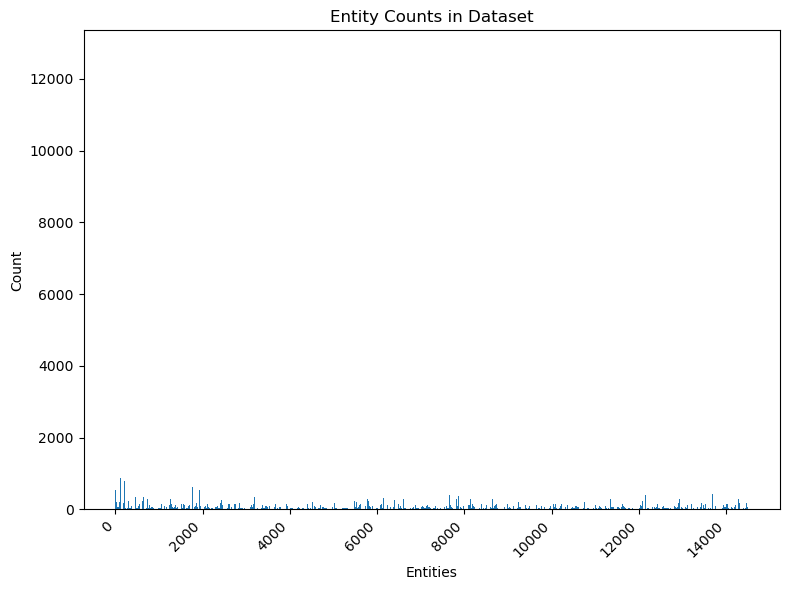

In [391]:
entities = list(entity_dict_whole.keys())
counts = list(entity_dict_whole.values())

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(entities, counts)

# Customize the plot
plt.title('Entity Counts in Dataset')
plt.xlabel('Entities')
plt.ylabel('Count')

# Rotate x-axis labels if there are many entities
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

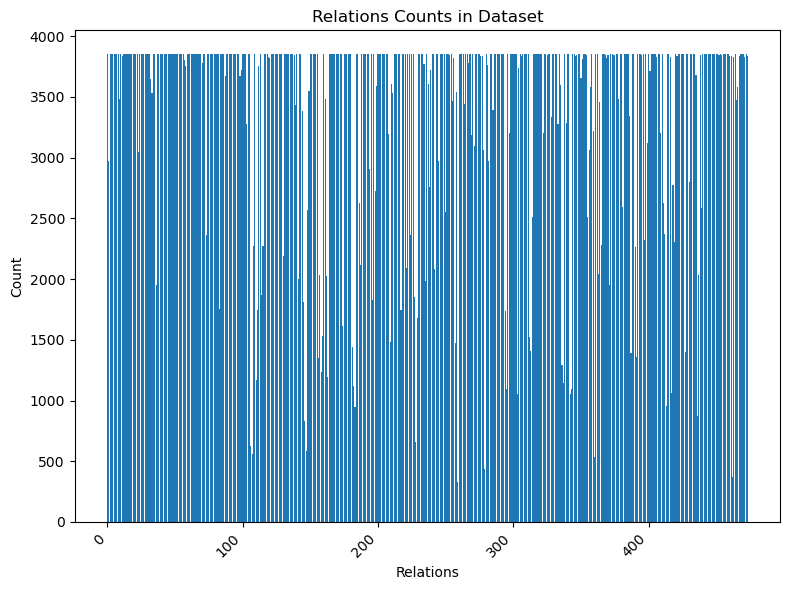

In [392]:
relations = list(relation_dict_whole.keys())
counts = list(relation_dict_whole.values())

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(relations, counts)

# Customize the plot
plt.title('Relations Counts in Dataset')
plt.xlabel('Relations')
plt.ylabel('Count')

# Rotate x-axis labels if there are many entities
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

In [40]:
len(query_data[list(query_data.keys())[0]])

16771

In [283]:
df = pd.DataFrame({
    "Relations": relations,
    "Counts": counts,
})

In [285]:
df.iloc[df['Counts'].sort_values()[-15:].index, :]

,Relations,Counts
160,81,3601
39,50,3601
37,160,3601
78,428,3601
216,105,3601
218,134,3601
30,458,3601
224,48,3601
157,127,3601
427,3,3601


In [159]:
max(relation_dict.values())

202

In [502]:
entity_dict.values()

dict_values([2, 8, 2, 4, 5, 4, 4, 2, 4, 4, 4, 4, 1, 4, 8, 5, 4, 4, 3, 4, 8, 4, 1, 4, 1, 4, 3, 3, 1, 4, 5, 5, 4, 3, 3, 11, 7, 6, 6, 4, 5, 4, 1, 4, 2, 4, 4, 1, 4, 3, 8, 1, 6, 4, 4, 4, 3, 2, 1, 4, 4, 4, 2, 4, 4, 4, 4, 4, 8, 8, 9, 6, 4, 8, 4, 6, 4, 4, 4, 4, 4, 4, 6, 1, 3, 4, 3, 3, 6, 3, 4, 2, 4, 2, 4, 4, 8, 4, 1, 1, 4, 4, 1, 4, 4, 6, 4, 4, 1, 4, 4, 4, 3, 1, 4, 3, 4, 7, 3, 4, 4, 5, 5, 3, 4, 4, 1, 6, 4, 1, 4, 2, 5, 5, 4, 4, 1, 4, 4, 1, 4, 10, 8, 5, 4, 4, 4, 8, 4, 1, 8, 1, 2, 1, 2, 7, 4, 5, 4, 4, 3, 4, 1, 7, 9, 4, 2, 5, 1, 4, 4, 4, 4, 2, 3, 4, 4, 2, 3, 4, 5, 4, 7, 1, 4, 4, 4, 6, 7, 6, 5, 4, 2, 1, 6, 3, 1, 5, 4, 1, 4, 1, 7, 4, 4, 4, 5, 4, 2, 4, 5, 4, 2, 1, 4, 4, 3, 2, 1, 5, 2, 4, 7, 8, 4, 1, 4, 1, 4, 3, 4, 3, 4, 4, 4, 6, 4, 1, 4, 8, 2, 7, 4, 4, 2, 3, 4, 4, 8, 4, 4, 12, 4, 2, 4, 1, 8, 1, 6, 1, 6, 4, 4, 1, 4, 2, 1, 4, 3, 2, 4, 3, 2, 5, 8, 1, 2, 4, 4, 7, 4, 8, 1, 3, 2, 8, 7, 4, 1, 1, 3, 4, 4, 3, 4, 3, 5, 5, 2, 7, 4, 4, 4, 1, 4, 1, 6, 2, 4, 3, 2, 4, 1, 6, 4, 2, 6, 5, 5, 8, 8, 4, 3, 5, 5, 7, 1, 4, 

In [407]:
# with open('data/random_query_2k_0007.pickle', 'wb') as file:
#     pickle.dump(query_data, file)

In [408]:
# with open('data/random_query_answer_2k_0007.pickle', "wb") as file1:
#     pickle.dump(answer_data, file1)
# answer_data

{(7961, (261,)): {9, 117},
 (7961, (8,)): {117},
 (7961, (10,)): {9},
 (14500, (92,)): {9740},
 (12701, (31,)): {158},
 (12701, (124,)): {158},
 (12701, (133,)): {12164},
 (12701, (389,)): {13060},
 (12617, (261,)): {9, 11},
 (12617, (10,)): {11},
 (12617, (8,)): {11},
 (12935, (50,)): {62},
 (12935, (188,)): {3294},
 (12935, (31,)): {119},
 (12935, (266,)): {119},
 (8389, (52,)): {342, 4864},
 (8389, (15,)): {839, 1060},
 (12096, (124,)): {637},
 (12096, (410,)): {637},
 (12096, (31,)): {637},
 (12096, (308,)): {2620},
 (13293, (96,)): {32},
 (13293, (464,)): {160},
 (13293, (34,)): {1192},
 (13293, (86,)): {141},
 (6555, (17,)): {5263, 7972},
 (6555, (6,)): {5263},
 (6555, (16,)): {7972},
 (8874, (185,)): {212},
 (8874, (41,)): {10188},
 (8874, (95,)): {2399},
 (8874, (38,)): {2399},
 (13231, (286,)): {2474},
 (13231, (166,)): {12189},
 (13213, (96,)): {1928},
 (13213, (351,)): {11503},
 (13213, (350,)): {11503},
 (13213, (34,)): {862},
 (14333, (63,)): {4519, 6021},
 (9831, (50,)): 

In [78]:
answer_data

{}

In [79]:
len(query_data[list(query_data.keys())[0]])

0

In [80]:
relations = []
for query in query_data[list(query_data.keys())[0]]:
    print(tuple(query)[1][0])
    relations.append()

## 쿼리 타입별 모듈

### 1p

In [15]:
# 1p
query_to_answers = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)


for start, end, data1 in edges1:
    rel1 = tuple(data1.values())
    query = (start, rel1)

    if query not in query_to_answers:
        query_to_answers[query] = {'answer': [], 'bounded': []}

    query_to_answers[query]['answer'].append(answer)
    # print(f"출발 노드: {start}, 도착 노드: {end}, 데이터: {tuple(rel)}")


NameError: name 'answer' is not defined

### 2p

In [52]:
# 2p
query_to_answers = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)



for start, bounded1, data1 in edges1:
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for _, end, data2 in edges2:

        # loop query 방지
        if end == start:
            continue

        rel2 = tuple(data2.values()) 

        # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
        query = (start, rel1 + rel2)
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        query_to_answers[query]['bounded'].append(bounded1)

In [56]:
'''
degree 가중치
'''
# 2p
query_to_answers = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

for itr_count1, (start, bounded1, data1) in enumerate(edges1):
    if itr_count1 >= wgh1:
        break
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for itr_count2, (_, end, data2) in enumerate(edges2):
        if itr_count2 >= wgh1:
            break

        # loop query 방지
        if end == start:
            continue

        rel2 = tuple(data2.values()) 

        # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
        query = (start, rel1 + rel2)
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        query_to_answers[query]['bounded'].append(bounded1)

### 3p

In [58]:
# 3p

query_to_answers = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

for start, bounded1, data1 in edges1:
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for _, bounded2, data2 in edges2:
        # loop query 방지
        if bounded2 == start:
            continue
        rel2 = tuple(data2.values()) 
        # 세 번째 edge
        edges3 = mG.out_edges(bounded2, keys=False, data=True)
        for _, end, data3 in edges3:
            # loop query 방지
            if end == start or end == bounded1:
                continue
            rel3 = tuple(data3.values()) 
            # print(f"출발 노드: {start}, 중간 노드: {(bounded1, bounded2)}, 도착 노드: {end}, 데이터: {rel1 + rel2 + rel3}")

            query = (start, rel1 + rel2 + rel3)
            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}
            query_to_answers[query]['answer'].append(end)
            query_to_answers[query]['bounded'].append((bounded1, bounded2))

In [59]:
# 3p
'''
degree 가중치
'''

query_to_answers = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

for itr_count1, (start, bounded1, data1) in enumerate(edges1):
    if itr_count1 >= wgh2:
        break
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for itr_count2, (_, bounded2, data2) in enumerate(edges2):
        if itr_count2 >= wgh2:
            break

        # loop query 방지
        if bounded2 == start:
            continue
        rel2 = tuple(data2.values()) 
        # 세 번째 edge
        edges3 = mG.out_edges(bounded2, keys=False, data=True)
        for itr_count3, (_, end, data3) in enumerate(edges3):
            if itr_count3 >= wgh2:
                break
            # loop query 방지
            if end == start or end == bounded1:
                continue
            rel3 = tuple(data3.values()) 
            # print(f"출발 노드: {start}, 중간 노드: {(bounded1, bounded2)}, 도착 노드: {end}, 데이터: {rel1 + rel2 + rel3}")

            query = (start, rel1 + rel2 + rel3)
            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}
            query_to_answers[query]['answer'].append(end)
            query_to_answers[query]['bounded'].append((bounded1, bounded2))

### 2i

In [120]:
# 2i 쿼리

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for start1, end, data1 in edges1:
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for start2, _, data2 in edges2:
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = ((start1, rel1), (start2, rel2))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        
        # 결과 출력 및 저장
        # print(f"출발 노드1: {start1}, 출발 노드2: {start2}, 도착 노드: {end}, 데이터: {rel1 + rel2}")

In [130]:
'''
degree weight
'''
# 2i

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for itr_count1, (start1, end, data1) in enumerate(edges1):
    if itr_count1 >= wgh1:
        break
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for itr_count2, (start2, _, data2) in enumerate(edges2):
        if itr_count2 >= wgh1:
            break
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = ((start1, rel1), (start2, rel2))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)

### 3i

In [136]:
# 3i 쿼리

query_to_answers = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for start1, end, data1 in edges1:
    rel1 = tuple(data1.values())
    num_rel = 0
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for start2, _, data2 in edges2:
        

        if start2 == start1:
            continue

        if num_rel == 0:
            start2_1 = start2
            rel2 = tuple(data2.values())
        elif num_rel == 1:
            start2_2 = start2
            rel3 = tuple(data2.values())
        num_rel += 1
            
        if num_rel == 2:
            query = ((start1, rel1), (start2_1, rel2), (start2_2, rel3))
            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}
            query_to_answers[query]['answer'].append(end)
            num_rel = 0
            
            # 결과 출력 및 저장
            # print(f"출발 노드1: {start1}, 출발 노드2: {start2_1}, 출발 노드3: {start2_2}, 도착 노드: {end}, 데이터: {rel1 + rel2 + rel3}")

In [134]:
# 3i 쿼리

query_to_answers = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for itr_count1, (start1, end, data1) in enumerate(edges1):
    if itr_count1 >= wgh1:
        break

    rel1 = tuple(data1.values())
    num_rel = 0
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for itr_count2, (start2, _, data2) in enumerate(edges2):
        if itr_count2 >= wgh1:
            break
        

        if start2 == start1:
            continue

        if num_rel == 0:
            start2_1 = start2
            rel2 = tuple(data2.values())
        elif num_rel == 1:
            start2_2 = start2
            rel3 = tuple(data2.values())
        num_rel += 1
            
        if num_rel == 2:
            query = ((start1, rel1), (start2_1, rel2), (start2_2, rel3))
            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}
            query_to_answers[query]['answer'].append(end)
            num_rel = 0

### ip

In [144]:
#ip

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for start1, end, data1 in edges1:
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for start2, _, data2 in edges2:
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = ((start1, rel1), (start2, rel2))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)

list_2i = list(query_to_answers.keys())
boundeds = [x['answer'][0] for x in query_to_answers.values()]
query_to_answers = {}

for k in tqdm(range(len(list_2i))):
    bounded1 = boundeds[k]
    start1 = list_2i[k][0][0]
    start2 = list_2i[k][1][0]
    rel1 = (list_2i[k][0][1][0],)
    rel2 = (list_2i[k][1][1][0],)

    # 세 번째 edge
    edges3 = mG.out_edges(bounded1, keys=False, data=True)
    for _, end, data3 in edges3:
        if end == start1 or end == start2:
            continue

        rel3 = tuple(data3.values())
        query = (((start1, rel1), (start2, rel2)), rel3)
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        query_to_answers[query]['bounded'].append(bounded1)
        
#         # 결과 출력 및 저장
#         # print(f"query: {query}")



100%|██████████| 19903/19903 [01:25<00:00, 232.77it/s] 


In [145]:
'''
degree weight
'''

#ip

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for itr_count1, (start1, end, data1) in enumerate(edges1):
    if itr_count1 >= wgh1:
        break
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for itr_count2, (start2, _, data2) in enumerate(edges2):
        if itr_count2 >= wgh1:
            break
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = ((start1, rel1), (start2, rel2))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)

list_2i = list(query_to_answers.keys())
boundeds = [x['answer'][0] for x in query_to_answers.values()]
query_to_answers = {}

for k in tqdm(range(len(list_2i))):
    
    bounded1 = boundeds[k]
    start1 = list_2i[k][0][0]
    start2 = list_2i[k][1][0]
    rel1 = (list_2i[k][0][1][0],)
    rel2 = (list_2i[k][1][1][0],)

    # 세 번째 edge
    edges3 = mG.out_edges(bounded1, keys=False, data=True)
    for itr_count3, (_, end, data3) in enumerate(edges3):
        if itr_count3 >= wgh1:
            break
        if end == start1 or end == start2:
            continue

        rel3 = tuple(data3.values())
        query = (((start1, rel1), (start2, rel2)), rel3)
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        query_to_answers[query]['bounded'].append(bounded1)

 16%|█▌        | 7/45 [00:00<00:00, 7592.48it/s]


### pi

In [63]:
# pi

'''
    2p와 1p의 결합
'''
query_to_answers = {}

# 2p
prepare = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

for start, bounded1, data1 in edges1:
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for _, end, data2 in edges2:

        # loop query 방지
        if end == start:
            continue

        rel2 = tuple(data2.values())

        # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
        query = (start, rel1 + rel2)
        if query not in prepare:
            prepare[query] = {'answer': [], 'bounded': []}
        prepare[query]['answer'].append(end)
        prepare[query]['bounded'].append(bounded1)

list_2p = list(prepare.keys())
ends = [x['answer'] for x in prepare.values()]

for k, q_2p in enumerate(tqdm(list_2p)):

    # for end in ends[k]: # 쿼리 하나당 생성되는 모든 answer에 대해서 pi를 생성하려면 사용
    for j, end in enumerate(ends[k]):

        edges1 = mG.in_edges(end, keys=False, data=True)


        for start, _, data1 in edges1:
            if start == q_2p[0] or start in set(prepare[list_2p[0]]['bounded']):
                continue
            
            rel1 = tuple(data1.values())
            query = (q_2p, (start, rel1))

            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}

            query_to_answers[query]['answer'].append(end)
            query_to_answers[query]['bounded'].append(prepare[q_2p]['bounded'][j])

    # print(f"출발 노드: {start}, 도착 노드: {end}, 데이터: {tuple(rel)}")




100%|██████████| 270/270 [00:11<00:00, 23.08it/s]


In [183]:
'''
degree weight
'''
# pi

'''
    2p와 1p의 결합
'''
query_to_answers = {}

# 2p
prepare = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

for itr_count1, (start, bounded1, data1) in enumerate(edges1):
    if itr_count1 >= wgh1:
        break
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for itr_count2, (_, end, data2) in enumerate(edges2):
        if itr_count2 >= wgh1:
            break

        # loop query 방지
        if end == start:
            continue

        rel2 = tuple(data2.values())

        # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
        query = (start, rel1 + rel2)
        if query not in prepare:
            prepare[query] = {'answer': [], 'bounded': []}
        prepare[query]['answer'].append(end)
        prepare[query]['bounded'].append(bounded1)

list_2p = list(prepare.keys())
ends = [x['answer'] for x in prepare.values()]

for k, q_2p in enumerate(tqdm(list_2p)):
    # if k >= wgh1:
    #     break

    # for end in ends[k]: # 쿼리 하나당 생성되는 모든 answer에 대해서 pi를 생성하려면 사용
    for j, end in enumerate(ends[k]):

        edges1 = mG.in_edges(end, keys=False, data=True)


        for itr_count3, (start, _, data) in enumerate(edges1):
            if itr_count3 >= wgh1:
                break
            if start == q_2p[0] or start in set(prepare[list_2p[0]]['bounded']):
                continue
            
            rel1 = tuple(data1.values())
            query = (q_2p, (start, rel1))

            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}

            query_to_answers[query]['answer'].append(end)
            query_to_answers[query]['bounded'].append(prepare[q_2p]['bounded'][j])

100%|██████████| 29/29 [00:00<00:00, 2838.95it/s]


### inp

In [7]:
# inp

#ip + query 저장할 때 형식만 변환

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for start1, end, data1 in edges1:
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for start2, _, data2 in edges2:
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = ((start1, rel1), (start2, rel2))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)

list_2i = list(query_to_answers.keys())
boundeds = [x['answer'][0] for x in query_to_answers.values()]
print(len(list_2i))
print(len(boundeds))
query_to_answers = {}

for k in tqdm(range(len(list_2i))):
    bounded1 = boundeds[k]
    start1 = list_2i[k][0][0]
    start2 = list_2i[k][1][0]
    rel1 = (list_2i[k][0][1][0],)
    rel2 = (list_2i[k][1][1][0],)

    # 세 번째 edge
    edges3 = mG.out_edges(bounded1, keys=False, data=True)
    for _, end, data3 in edges3:
        if end == start1 or end == start2:
            continue

        rel3 = tuple(data3.values())

        query = (((start1, rel1), (start2, rel2 + (-2,))), rel3)
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        query_to_answers[query]['bounded'].append(bounded1)
        
#         # 결과 출력 및 저장
#         # print(f"query: {query}")



19903
19903


100%|██████████| 19903/19903 [01:33<00:00, 212.44it/s] 


In [ ]:
'''
degree weight
'''

#ip

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for itr_count1, (start1, end, data1) in enumerate(edges1):
    if itr_count1 >= wgh1:
        break
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for itr_count2, (start2, _, data2) in enumerate(edges2):
        if itr_count2 >= wgh1:
            break
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = ((start1, rel1), (start2, rel2))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)

list_2i = list(query_to_answers.keys())
boundeds = [x['answer'][0] for x in query_to_answers.values()]
query_to_answers = {}

for k in tqdm(range(len(list_2i))):
    
    bounded1 = boundeds[k]
    start1 = list_2i[k][0][0]
    start2 = list_2i[k][1][0]
    rel1 = (list_2i[k][0][1][0],)
    rel2 = (list_2i[k][1][1][0],)

    # 세 번째 edge
    edges3 = mG.out_edges(bounded1, keys=False, data=True)
    for itr_count3, (_, end, data3) in enumerate(edges3):
        if itr_count3 >= wgh1:
            break
        if end == start1 or end == start2:
            continue

        rel3 = tuple(data3.values())
        query = (((start1, rel1), (start2, rel2 + (-2,))), rel3)
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        query_to_answers[query]['bounded'].append(bounded1)

### pin

In [156]:
# pi

'''
    2p와 1p의 결합
'''
query_to_answers = {}

# 2p
prepare = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

for start, bounded1, data1 in edges1:
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for _, end, data2 in edges2:

        # loop query 방지
        if end == start:
            continue

        rel2 = tuple(data2.values())

        # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
        query = (start, rel1 + rel2)
        if query not in prepare:
            prepare[query] = {'answer': [], 'bounded': []}
        prepare[query]['answer'].append(end)
        prepare[query]['bounded'].append(bounded1)

list_2p = list(prepare.keys())
ends = [x['answer'] for x in prepare.values()]

for k, q_2p in enumerate(tqdm(list_2p)):

    # for end in ends[k]: # 쿼리 하나당 생성되는 모든 answer에 대해서 pi를 생성하려면 사용
    ends_one = [ends[k][0]] # 현재는 answer 중 첫 번째만 사용중
    for j, end in enumerate(ends[k]):

        edges1 = mG.in_edges(end, keys=False, data=True)


        for start, _, data1 in edges1:
            if start == q_2p[0] or start in set(prepare[list_2p[0]]['bounded']):
                continue
            
            rel1 = tuple(data1.values())
            query = (q_2p, (start, rel1 + (-2,)))

            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}

            query_to_answers[query]['answer'].append(end)
            query_to_answers[query]['bounded'].append(prepare[q_2p]['bounded'][j])

    # print(f"출발 노드: {start}, 도착 노드: {end}, 데이터: {tuple(rel)}")




  0%|          | 0/270 [00:00<?, ?it/s]

100%|██████████| 270/270 [00:16<00:00, 15.93it/s] 


In [155]:
'''
degree weight
'''
prepare = {}

node = i
edges1 = mG.out_edges(node, keys=False, data=True)

for itr_count1, (start, bounded1, data1) in enumerate(edges1):
    if itr_count1 >= wgh2:
        break
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for itr_count2, (_, end, data2) in enumerate(edges2):
        if itr_count2 >= wgh2:
            break

        # loop query 방지
        if end == start:
            continue

        rel2 = tuple(data2.values())

        # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
        query = (start, rel1 + rel2)
        if query not in prepare:
            prepare[query] = {'answer': [], 'bounded': []}
        prepare[query]['answer'].append(end)
        prepare[query]['bounded'].append(bounded1)

list_2p = list(prepare.keys())
ends = [x['answer'] for x in prepare.values()]

for k, q_2p in enumerate(tqdm(list_2p)):
    # if k >= wgh2:
    #     break

    # for end in ends[k]: # 쿼리 하나당 생성되는 모든 answer에 대해서 pi를 생성하려면 사용
    for j, end in enumerate(ends[k]):

        edges1 = mG.in_edges(end, keys=False, data=True)

        for itr_count3, (start, _, data) in enumerate(edges1):
            if itr_count3 >= wgh1:
                break
            if start == q_2p[0] or start in set(prepare[list_2p[0]]['bounded']):
                continue
            
            rel1 = tuple(data1.values())
            query = (q_2p, (start, rel1 + (-2,)))

            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}

            query_to_answers[query]['answer'].append(end)
            query_to_answers[query]['bounded'].append(prepare[q_2p]['bounded'][j])

 24%|██▍       | 7/29 [00:00<00:00, 277.05it/s]


### pni

In [30]:
# pi

'''
    2p와 1p의 결합
'''
query_to_answers = {}

# 2p
prepare = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

for start, bounded1, data1 in edges1:
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for _, end, data2 in edges2:

        # loop query 방지
        if end == start:
            continue

        rel2 = tuple(data2.values())

        # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
        query = (start, rel1 + rel2 + (-2,))
        if query not in prepare:
            prepare[query] = {'answer': [], 'bounded': []}
        prepare[query]['answer'].append(end)
        prepare[query]['bounded'].append(bounded1)

list_2p = list(prepare.keys())
ends = [x['answer'] for x in prepare.values()]

for k, q_2p in enumerate(tqdm(list_2p)):

    # for end in ends[k]: # 쿼리 하나당 생성되는 모든 answer에 대해서 pi를 생성하려면 사용
    ends_one = [ends[k][0]] # 현재는 answer 중 첫 번째만 사용중
    for end in ends_one:

        edges1 = mG.in_edges(end, keys=False, data=True)


        for start, _, data1 in edges1:
            if start == q_2p[0] or start in set(prepare[list_2p[0]]['bounded']):
                continue
            
            rel1 = tuple(data1.values())
            query = (q_2p, (start, rel1))

            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}

            query_to_answers[query]['answer'].append(end)
            query_to_answers[query]['bounded'] = prepare[q_2p]['bounded'][0] # answer 하나만 사용하니까 bounded도 하나만 사용

100%|██████████| 270/270 [00:00<00:00, 463.78it/s]


In [ ]:
'''
degree weight
'''


prepare = {}

node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

for itr_count1, (start, bounded1, data1) in enumerate(edges1):
    if itr_count1 >= wgh2:
        break
    rel1 = tuple(data1.values())  # 첫 번째 edge
    
    # 두 번째 edge
    edges2 = mG.out_edges(bounded1, keys=False, data=True)
    for itr_count2, (_, end, data2) in enumerate(edges2):
        if itr_count2 >= wgh2:
            break

        # loop query 방지
        if end == start:
            continue

        rel2 = tuple(data2.values())

        # print(f"출발 노드: {start}, 중간 노드: {bounded}, 도착 노드: {end}, 데이터: {rel1 + rel2}")
        query = (start, rel1 + rel2)
        if query not in prepare:
            prepare[query] = {'answer': [], 'bounded': []}
        prepare[query]['answer'].append(end)
        prepare[query]['bounded'].append(bounded1)

list_2p = list(prepare.keys())
ends = [x['answer'] for x in prepare.values()]

for k, q_2p in enumerate(tqdm(list_2p)):
    # if k >= wgh2:
    #     break

    # for end in ends[k]: # 쿼리 하나당 생성되는 모든 answer에 대해서 pi를 생성하려면 사용
    for j, end in enumerate(ends[k]):

        edges1 = mG.in_edges(end, keys=False, data=True)

        for itr_count3, (start, _, data) in enumerate(edges1):
            if itr_count3 >= wgh1:
                break
            if start == q_2p[0] or start in set(prepare[list_2p[0]]['bounded']):
                continue
            
            rel1 = tuple(data1.values())
            query = (q_2p, (start, rel1))

            if query not in query_to_answers:
                query_to_answers[query] = {'answer': [], 'bounded': []}

            query_to_answers[query]['answer'].append(end)
            query_to_answers[query]['bounded'].append(prepare[q_2p]['bounded'][j])

### 2u

In [39]:
# 2i 쿼리 + u flag

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for start1, end, data1 in edges1:
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for start2, _, data2 in edges2:
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = (((start1, rel1), (start2, rel2)), (-1,))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        
        # 결과 출력 및 저장
        # print(f"출발 노드1: {start1}, 출발 노드2: {start2}, 도착 노드: {end}, 데이터: {rel1 + rel2}")

In [ ]:
'''
degree weight
'''
# 2i

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for itr_count1, (start1, end, data1) in enumerate(edges1):
    if itr_count1 >= wgh1:
        break
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for itr_count2, (start2, _, data2) in enumerate(edges2):
        if itr_count2 >= wgh1:
            break
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = (((start1, rel1), (start2, rel2)), (-1,))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)

### up

In [41]:
#ip + 'u' relation flag

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for start1, end, data1 in edges1:
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for start2, _, data2 in edges2:
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = ((start1, rel1), (start2, rel2))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)

list_2i = list(query_to_answers.keys())
boundeds = [x['answer'][0] for x in query_to_answers.values()]
query_to_answers = {}

for k in tqdm(range(len(list_2i))):
    bounded1 = boundeds[k]
    start1 = list_2i[k][0][0]
    start2 = list_2i[k][1][0]
    rel1 = (list_2i[k][0][1][0],)
    rel2 = (list_2i[k][1][1][0],)

    # 세 번째 edge
    edges3 = mG.out_edges(bounded1, keys=False, data=True)
    for _, end, data3 in edges3:
        if end == start1 or end == start2:
            continue

        rel3 = tuple(data3.values())
        query = (((start1, rel1), (start2, rel2), (-1,)), rel3)
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        query_to_answers[query]['bounded'].append(bounded1)
        
#         # 결과 출력 및 저장
#         # print(f"query: {query}")



100%|██████████| 19903/19903 [01:26<00:00, 230.39it/s] 


In [ ]:
'''
degree weight
'''

#up

query_to_answers = {}
node = 0
edges1 = mG.out_edges(node, keys=False, data=True)

# 첫 번째 edge
for itr_count1, (start1, end, data1) in enumerate(edges1):
    if itr_count1 >= wgh1:
        break
    rel1 = tuple(data1.values())
    
    # 두 번째 edge
    edges2 = mG.in_edges(end, keys=False, data=True)
    for itr_count2, (start2, _, data2) in enumerate(edges2):
        if itr_count2 >= wgh1:
            break
        if start2 == start1:
            continue

        rel2 = tuple(data2.values())

        query = ((start1, rel1), (start2, rel2))
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)

list_2i = list(query_to_answers.keys())
boundeds = [x['answer'][0] for x in query_to_answers.values()]
query_to_answers = {}

for itr_count3, k in enumerate(tqdm(range(len(list_2i)))):
    if itr_count3 >= wgh1:
        break
    
    bounded1 = boundeds[k]
    start1 = list_2i[k][0][0]
    start2 = list_2i[k][1][0]
    rel1 = (list_2i[k][0][1][0],)
    rel2 = (list_2i[k][1][1][0],)

    # 세 번째 edge
    edges3 = mG.out_edges(bounded1, keys=False, data=True)
    for _, end, data3 in edges3:
        if end == start1 or end == start2:
            continue

        rel3 = tuple(data3.values())
        query = (((start1, rel1), (start2, rel2), (-1,)), rel3)
        if query not in query_to_answers:
            query_to_answers[query] = {'answer': [], 'bounded': []}
        query_to_answers[query]['answer'].append(end)
        query_to_answers[query]['bounded'].append(bounded1)

## 생성된 dictionary 확인

In [154]:
print("Qeury: ", list(query_to_answers.keys())[0])
print(query_to_answers[list(query_to_answers.keys())[0]])
print(query_to_answers[list(query_to_answers.keys())[0]]['answer'])
print(query_to_answers[list(query_to_answers.keys())[0]]['bounded'])
query_to_answers

Qeury:  ((0, (0, 1)), (2068, (116,)))
{'answer': [2069], 'bounded': [1]}
[2069]
[1]


{((0, (0, 1)), (2068, (116,))): {'answer': [2069], 'bounded': [1]},
 ((0, (0, 1)), (2068, (117,))): {'answer': [2069], 'bounded': [1]},
 ((0, (0, 1)), (420, (125,))): {'answer': [2069, 1705, 8576, 10167, 4875],
  'bounded': [1, 1, 1, 1, 1]},
 ((0, (0, 1)), (160, (443,))): {'answer': [2069, 10167], 'bounded': [1, 1]},
 ((0, (0, 1)), (160, (140,))): {'answer': [2069, 10167], 'bounded': [1, 1]},
 ((0, (0, 1)), (853, (116,))): {'answer': [2069], 'bounded': [1]},
 ((0, (0, 1)), (853, (117,))): {'answer': [2069], 'bounded': [1]},
 ((0, (0, 1)), (57, (47,))): {'answer': [2069, 1705, 10167],
  'bounded': [1, 1, 1]},
 ((0, (0, 1)), (4494, (1,))): {'answer': [2069, 1705, 10167, 4875],
  'bounded': [1, 1, 1, 1]},
 ((0, (0, 1)), (4136, (47,))): {'answer': [2069, 10167], 'bounded': [1, 1]},
 ((0, (0, 1)), (8821, (47,))): {'answer': [2069, 8576, 10167, 4875],
  'bounded': [1, 1, 1, 1]},
 ((0, (0, 1)), (2069, (270,))): {'answer': [2069], 'bounded': [1]},
 ((0, (0, 1)), (2069, (271,))): {'answer': [20

## 부록

In [ ]:
# set 방식 시도 ==> 겹치는 set 찾는 과정 필요
node1 = 0
node2 = 4
edges1 = mG.out_edges(node1, keys=False, data=True)

# 첫 번째 edge
bounded1 = set()
for _, bounded, _ in edges1:
    bounded1.add(bounded)

edges2 = mG.out_edges(node2, keys=False, data=True)
# 두 번째 edge
bounded2 = set()
for _, bounded, _ in edges2:
    bounded2.add(bounded)

end = list(set(bounded1 & bounded2) - set([node1,node2]))
print(end)

print(mG.get_edge_data(node1,end[0]))
print(mG.get_edge_data(node2,end[0]))